# Lab 2: Neural Machine Translation in the wild

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

## Основные требования к экспериментам:
Пожалуйста, проведите не менее четырех различных экспериментов (степень различия может варьироваться). В каждом эксперименте:

* Опишите основную идею эксперимента, проиллюстрируйте процесс обучения с помощью графиков
* Оцените полученные результаты перевода используя подходящие критерии качества (Perplexity/BLEU/...)
* Приведите удачные и неудачные примеры перевода (по 2-3 предложения будет достаточно)
* Оцените скорость обучения модели (с точки зрения затраченного времени) и количество пар использованных примеров (число эпох * число обработанных батчей за одну эпоху * размер батча)
* Оцените степень переобучения модели
* Оцените скорость применения модели в режиме inference в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)


In [ ]:
# Required libs
! pip install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import spacy
import random
import math
import time
import imp
import os
import shutil
import numpy as np

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from google.colab import drive

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)
path = 'gdrive/MyDrive/MADE_NLP_2021_Lab_02_DL_translation'

Mounted at /content/gdrive/


In [ ]:
# TODO: replace this part with my github folder after contest finishing

path_to_data = f'{path}/data/data.txt'
if not os.path.exists(path_to_data):
    print(f'Dataset not found at {path}!')
    #!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    #path_do_data = './data.txt'

path_to_src_emb = '/content/ft_native_300_ru_wiki_lenta_lower_case.vec'
if not os.path.exists(path_to_src_emb):
    print("enc emb weights not found locally. Downloading from deeppavlov.ai.")
    url = 'http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_lower_case/ft_native_300_ru_wiki_lenta_lower_case.vec'
    !wget $url

path_to_utils = f'{path}/utils.py'
if not os.path.exists(path_to_utils):
    print(f'Utils file not found at {path}!')
    #!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

path_to_network = f'{path}/network.py'
if not os.path.exists(path_to_network):
    print(f'Network file not found at {path}!')
    #!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [ ]:
!cp $path_to_network .
!cp $path_to_utils .

import network
import utils
imp.reload(network)
imp.reload(utils)

<module 'utils' from '/content/utils.py'>

### Dataset part

In [ ]:
train_data, valid_data, test_data, SRC, TRG = utils.prepare_data(path_to_data, path_to_src_emb)


Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9233
Unique tokens in target (en) vocabulary: 6694


### Model side

In [ ]:
def train(
    model, iterator, optimizer, criterion,
    scheduler=None, clip=1,
    train_history=None,
    valid_history=None,
    lr_history=None
):
    model.train()

    epoch_loss = 0

    history = []

    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_ylabel('Train loss')
            if lr_history is not None:
                ax[1].plot(lr_history, label='general lr history')
                ax[1].set_xlabel('Epoch')
                ax[1].set_ylabel('LR')
            if train_history is not None:
                ax[2].plot(train_history, label='general train history')
                ax[2].set_xlabel('Epoch')
            if valid_history is not None:
                ax[2].plot(valid_history, label='general valid history')
                ax[2].set_xlabel('Epoch')
            
            plt.legend()
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0

    batch_time = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            start_time = time.time()
            output = model(src, trg, 0) #turn off teacher forcing
            batch_time.append((time.time() - start_time) / len(batch)) #track time

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), np.mean(batch_time)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def run_training(
    model, train_iterator, valid_iterator,
    optimizer, criterion, scheduler,
    clip, n_epochs, n_batch
):

    ep_time_history = []
    batch_time_history = []
    train_history = []
    valid_history = []
    lr_history = []

    best_valid_loss = float('inf')
    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss = train(model, train_iterator, optimizer, criterion, scheduler, clip, train_history, valid_history, lr_history)
        valid_loss, mean_batch_time = evaluate(model, valid_iterator, criterion)
        end_time = time.time()
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            filename = f'model_{model.name}_best.pt'
            torch.save(model.state_dict(), filename)
            shutil.copyfile(filename, f'{path}/{filename}')

        ep_time_history.append((start_time, end_time))
        batch_time_history.append(mean_batch_time)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        lr_history.append(utils.get_lr(optimizer))

    total_time = 0
    for epoch in range(n_epochs):
        epoch_mins, epoch_secs = epoch_time(ep_time_history[epoch][0], ep_time_history[epoch][1])
        mean_batch_time = batch_time_history[epoch]
        train_loss = train_history[epoch]
        valid_loss = valid_history[epoch]
        lr = lr_history[epoch]
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tMean inference time per 32 batch: {mean_batch_time * (32. / n_batch):3f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print(f'\t        LR: {lr}')
        total_time += epoch_mins * 60 + epoch_secs
    print(f'Total time: {total_time//60}m {total_time%60}s')


def check_best_model(model, best_weights_path, trg_vocab, test_iterator):
    print("Translation examples")
    model.load_state_dict(torch.load(best_weights_path))
    utils.get_translation_sample(model, trg_vocab, test_iterator, cnt=5)
    print("BLUE score", utils.corpus_blue_accuracy(model, trg_vocab, test_iterator))

### Experiments

In [ ]:
def construct_nmt_model(device, exp_name, src_vocab, trg_vocab, use_emb_weights=False):
    # parameters
    INPUT_DIM = len(src_vocab)
    OUTPUT_DIM = len(trg_vocab)
    ENC_EMB_DIM = 300
    DEC_EMB_DIM = 300
    HID_DIM = 512
    N_LAYERS = 2
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5
    ENC_EMB_WEIGHTS = src_vocab.vectors if use_emb_weights else None
    DEC_EMB_WEIGHTS = trg_vocab.vectors if use_emb_weights else None
    # build model
    enc = network.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, ENC_EMB_WEIGHTS)
    dec = network.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, DEC_EMB_WEIGHTS)
    model = network.Seq2Seq(enc, dec, device, exp_name).to(device)
    model.apply(network.init_weights)
    print(model)
    return model

### Experiment 0: Baseline

Запустим бейзлайн через реализованные скрипты, чтобы его результат был перед глазами

In [ ]:
EXP_NAME = "baseline"
PAD_IDX = TRG.vocab.stoi['<pad>']
BATCH_SIZE = 128
N_EPOCHS = 10
CLIP = 1
LR = 0.001

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=(lambda x : len(x.src)),
    batch_size = BATCH_SIZE, 
    device = device,
)

print(f'Experiment: {EXP_NAME}')
model = construct_nmt_model(device, EXP_NAME, SRC.vocab, TRG.vocab)
print(f'The model has {network.count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Experiment: baseline
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9233, 300)
    (rnn): LSTM(300, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6694, 300)
    (rnn): LSTM(300, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6694, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 15,748,762 trainable parameters


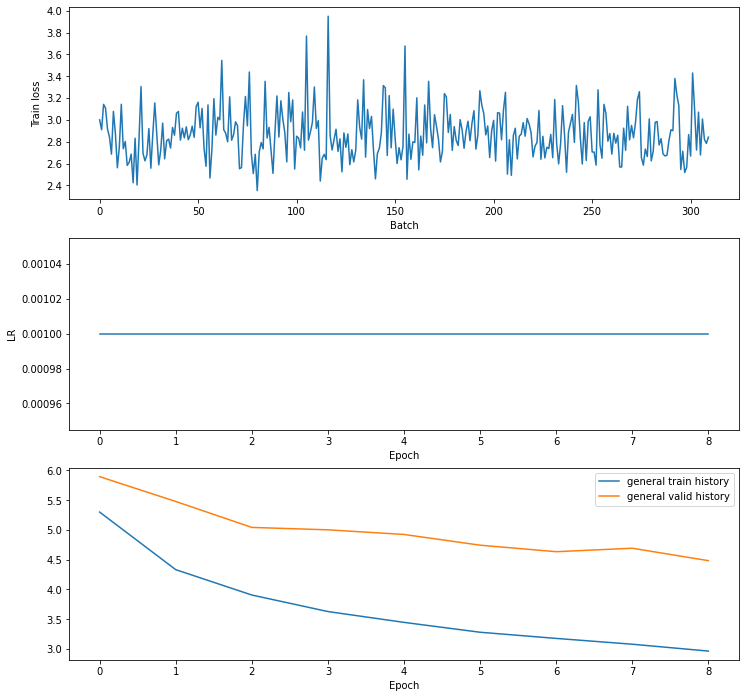

Epoch: 01 | Time: 1m 26s
	Mean inference time per 32 batch: 0.000098s
	Train Loss: 5.300 | Train PPL: 200.433
	 Val. Loss: 5.895 |  Val. PPL: 363.374
	        LR: 0.001
Epoch: 02 | Time: 1m 26s
	Mean inference time per 32 batch: 0.000099s
	Train Loss: 4.333 | Train PPL:  76.167
	 Val. Loss: 5.479 |  Val. PPL: 239.506
	        LR: 0.001
Epoch: 03 | Time: 1m 27s
	Mean inference time per 32 batch: 0.000099s
	Train Loss: 3.907 | Train PPL:  49.732
	 Val. Loss: 5.043 |  Val. PPL: 154.885
	        LR: 0.001
Epoch: 04 | Time: 1m 28s
	Mean inference time per 32 batch: 0.000101s
	Train Loss: 3.629 | Train PPL:  37.675
	 Val. Loss: 5.002 |  Val. PPL: 148.733
	        LR: 0.001
Epoch: 05 | Time: 1m 26s
	Mean inference time per 32 batch: 0.000101s
	Train Loss: 3.447 | Train PPL:  31.412
	 Val. Loss: 4.924 |  Val. PPL: 137.595
	        LR: 0.001
Epoch: 06 | Time: 1m 27s
	Mean inference time per 32 batch: 0.000098s
	Train Loss: 3.281 | Train PPL:  26.606
	 Val. Loss: 4.744 |  Val. PPL: 114.916
	    

In [ ]:
run_training(model,
             train_iterator, valid_iterator,
             optimizer, criterion, scheduler=None,
             clip=CLIP, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE)

In [ ]:
best_weights_path = f'{path}/model_{model.name}_best.pt'
check_best_model(model, best_weights_path, TRG.vocab, test_iterator)

0it [00:00, ?it/s]

Translation examples
Original: breakfast can also be ordered there .
Generated: guests can enjoy a meal in the room .

Original: free private parking is also available at this apartment .
Generated: free private parking is available .

Original: linen is provided .
Generated: some have a private .

Original: there is a 24 - hour front desk at the property .
Generated: the 24 - hour front desk .

Original: a hairdryer can be requested .
Generated: airport is available upon request .



59it [00:03, 15.34it/s]


BLUE score 14.55701226070608


#### Предоставленный baseline имеет BLUE score *13.77*, цель -- 29

### Experiment 1: FastText embeddings

Используем предобученные эмбединги (RU -- из DeepPavlov, EN -- встроенный в torch)

In [ ]:
EXP_NAME = "exp_1_pretr_embs"
PAD_IDX = TRG.vocab.stoi['<pad>']
BATCH_SIZE = 128
N_EPOCHS = 20
CLIP = 1
LR = 0.005

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=(lambda x : len(x.src)),
    batch_size = BATCH_SIZE, 
    device = device,
)

print(f'Experiment: {EXP_NAME}')
model = construct_nmt_model(device, EXP_NAME, SRC.vocab, TRG.vocab, use_emb_weights=True)
print(f'The model has {network.count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR,
    steps_per_epoch=(len(train_data) + BATCH_SIZE)//BATCH_SIZE,
    epochs=N_EPOCHS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Experiment: exp_1_pretr_embs
Set pretrained weights for encoder.embedding.weight
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1107,  0.4729,  0.0873,  ..., -0.1447, -0.0150, -0.4766],
        [ 0.4092,  0.0317,  0.0230,  ..., -0.1866, -0.1622, -0.2547],
        [ 0.0882, -0.3117,  0.1331,  ...,  0.0131, -0.1955, -0.1007]],
       device='cuda:0', requires_grad=True)
Set pretrained weights for decoder.embedding.weight
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedd

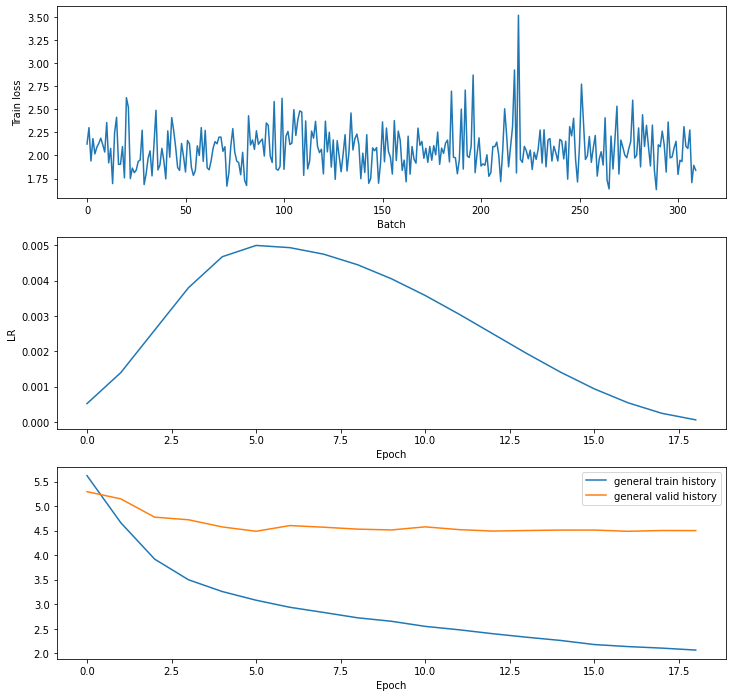

Epoch: 01 | Time: 1m 26s
	Mean inference time per 32 batch: 0.000102s
	Train Loss: 5.620 | Train PPL: 275.938
	 Val. Loss: 5.294 |  Val. PPL: 199.191
	        LR: 0.0005218738579355455
Epoch: 02 | Time: 1m 27s
	Mean inference time per 32 batch: 0.000099s
	Train Loss: 4.661 | Train PPL: 105.729
	 Val. Loss: 5.147 |  Val. PPL: 171.898
	        LR: 0.0014011597813902558
Epoch: 03 | Time: 1m 26s
	Mean inference time per 32 batch: 0.000100s
	Train Loss: 3.920 | Train PPL:  50.410
	 Val. Loss: 4.775 |  Val. PPL: 118.524
	        LR: 0.002602008476688475
Epoch: 04 | Time: 1m 28s
	Mean inference time per 32 batch: 0.000101s
	Train Loss: 3.500 | Train PPL:  33.112
	 Val. Loss: 4.722 |  Val. PPL: 112.408
	        LR: 0.0038023184418697845
Epoch: 05 | Time: 1m 27s
	Mean inference time per 32 batch: 0.000099s
	Train Loss: 3.260 | Train PPL:  26.047
	 Val. Loss: 4.576 |  Val. PPL:  97.081
	        LR: 0.004680132677591358
Epoch: 06 | Time: 1m 27s
	Mean inference time per 32 batch: 0.000098s
	Train 

In [ ]:
run_training(model,
             train_iterator, valid_iterator,
             optimizer, criterion, scheduler=scheduler,
             clip=CLIP, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE)

In [ ]:
best_weights_path = f'{path}/model_{model.name}_best.pt'
check_best_model(model, best_weights_path, TRG.vocab, test_iterator)

0it [00:00, ?it/s]

Translation examples
Original: breakfast can also be ordered there .
Generated: breakfast is served daily .

Original: free private parking is also available at this apartment .
Generated: free private parking is available on site .

Original: linen is provided .
Generated: bed linen .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: a hairdryer can be requested .
Generated: a , and a are provided upon request .



59it [00:03, 16.91it/s]


BLUE score 22.61878473091641
